In [16]:
# Import necessary libraries
import os
import warnings
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
import itertools
from sklearn import datasets
from scipy.optimize import fsolve
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
from sklearn.metrics import pairwise_distances
from sklearn.isotonic import IsotonicRegression
from metrics import *

In [17]:
if not os.path.isdir("figs"):
    os.mkdir("figs")

In [21]:
plt.rcParams.update({'font.size': 14})

In [19]:
# plt.style.use("seaborn-v0_8-paper")

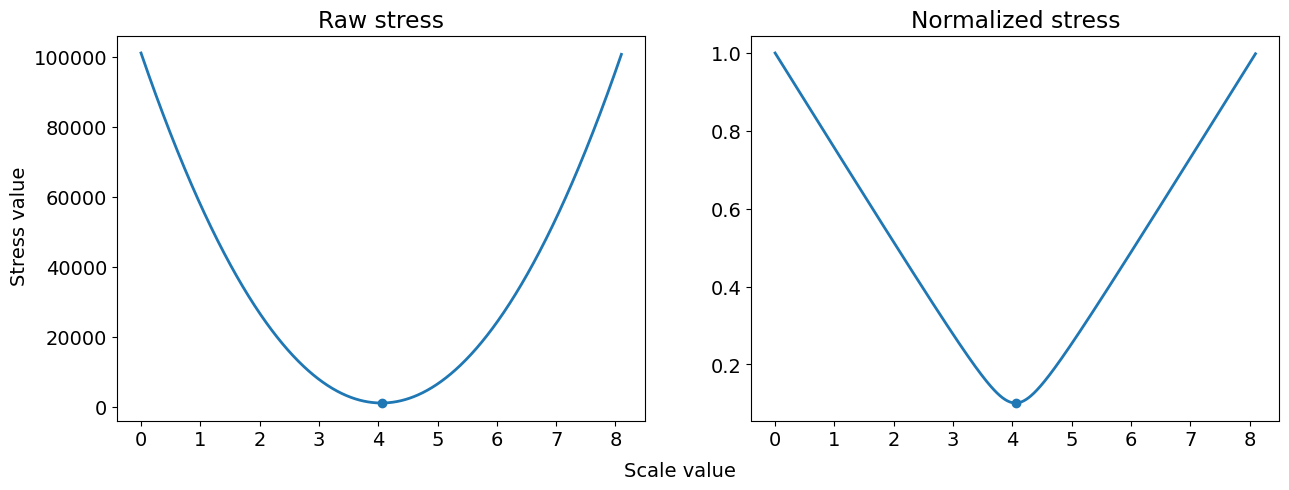

In [22]:
X = np.load("datasets/iris.npy")
Y = np.load("embeddings/iris_MDS_0.npy")

M = Metrics(X, Y)

scale_opt, alpha_opt = M.compute_scale_normalized_stress(return_alpha=True)

rrange = np.linspace(0, 8.1, 810)

norm_stress_scores = list()
raw_stress_scores = list()

# Compute normalized and raw stress for a range of scaling factors
for alpha in rrange:
    M.setY(alpha * Y)
    norm_stress_scores.append(M.compute_normalized_stress())
    raw_stress_scores.append(M.compute_raw_stress())

fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharex=True)

# Plot raw stress scores
axs[0].plot(rrange, raw_stress_scores, linewidth=2)
axs[0].scatter(rrange[np.argmin(raw_stress_scores)],
               min(raw_stress_scores))
axs[0].set_title("Raw stress")

# Plot normalized stress scores
axs[1].plot(rrange, norm_stress_scores, linewidth=2)
axs[1].scatter(alpha_opt, scale_opt)
axs[1].set_title("Normalized stress")

fig.text(0.5, 0.01, "Scale value", ha="center", va="center")
fig.text(0.06, 0.5, "Stress value", ha="center",
         va="center", rotation="vertical")

plt.savefig("./figs/figure_2.pdf", format="pdf")

In [14]:
warnings.filterwarnings("ignore")

# Load iris data
iris = datasets.load_iris()
df = pd.DataFrame(iris.data)
species = pd.DataFrame(iris.target)
df, species = df.drop_duplicates(), species.loc[df.drop_duplicates().index]
species = species.to_numpy().ravel()

colors = ["c", "y", "m"]

fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(3, 5, figure=fig)

for idx, (technique, llabel) in enumerate(zip(["MDS", "TSNE", "RANDOM"], ["MDS", "t-SNE", "Random"])):
    Y = np.load(f"embeddings/iris_{technique}_1.npy")

    ax = fig.add_subplot(gs[idx, 0])

    for color, i, target_name in zip(colors, [0, 1, 2], iris.target_names):
        ax.scatter(Y[species == i][:, 0], Y[species == i][:, 1], c=color,  alpha=.8,
                   label=target_name)

    ax.set_title(f"Iris dataset embedded with {llabel}")
    ax.legend(loc="best", shadow=False, scatterpoints=1)
    ax.set_xticks([])
    ax.set_yticks([])

    # Save each subplot as a separate pdf
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    for color, i, target_name in zip(colors, [0, 1, 2], iris.target_names):
        ax1.scatter(Y[species == i][:, 0], Y[species == i][:, 1], c=color,  alpha=.8,
                   label=target_name)
    ax1.set_title(f"Iris dataset embedded with {llabel}")
    ax1.legend(loc="best", shadow=False, scatterpoints=1)
    ax1.set_xticks([])
    ax1.set_yticks([])
    fig1.savefig(f"./figs/teaser_subplot_{idx}.pdf")
    plt.close(fig1)


rrange = np.linspace(0, 9, 900)

# Store all curves
curves = list()
norm_stress_scores = list()

ax = fig.add_subplot(gs[:, 1:])

X = np.load("datasets/iris.npy")
for (technique, llabel) in zip(["MDS", "TSNE", "RANDOM"], ["MDS", "t-SNE", "Random"]):
    Y = np.load(f"embeddings/iris_{technique}_1.npy")

    M = Metrics(X, Y)

    scale_opt, alpha_opt = M.compute_scale_normalized_stress(return_alpha=True)

    for alpha in rrange:
        M.setY(alpha * Y)
        norm_stress_scores.append(M.compute_normalized_stress())

    ax.plot(rrange, norm_stress_scores, label=llabel)

    # Mark the minimum point on each curve
    ax.scatter(alpha_opt, scale_opt, s=60)

    # Store the curve
    curves.append((rrange, norm_stress_scores.copy()))

    norm_stress_scores.clear()

# Find and mark intersections
intersection_label_added = False
intersection_points = []
for (scalars1, avg_stress1), (scalars2, avg_stress2) in itertools.combinations(curves, 2):
    # Define function for the difference between the two curves
    def func(x): return np.interp(x, scalars1, avg_stress1) - \
        np.interp(x, scalars2, avg_stress2)
    
    # Find the intersection points (excluding 0)
    x_intersections = fsolve(func, scalars1[1:])

    # Mark intersection points
    for x in x_intersections:
        if x >= 0 and x <= max(rrange):
            y = np.interp(x, scalars1, avg_stress1)

            if not any(abs(x - xi) < 0.1 for xi, _ in intersection_points):
                intersection_points.append((x, y))
                if not intersection_label_added:
                    ax.scatter(x, y, color="black", zorder=3,
                               s=60, label="Intersections")
                    intersection_label_added = True
                else:
                    ax.scatter(x, y, color="black", zorder=3, s=60)

ax.set_yscale("log")
ax.set_title("Iris")
ax.set_ylabel("log(Normalized stress)")
ax.set_xlabel("Scale value")
ax.legend(loc="best")

plt.tight_layout()
plt.savefig("./figs/teaser.pdf")
plt.close()

In [15]:
# Load penguins dataset
plt.rcParams.update({'font.size': 22})
data = sns.load_dataset('penguins').dropna(thresh=6)
cols_num = ['bill_length_mm', 'bill_depth_mm',
            'flipper_length_mm', 'body_mass_g']
X = data[cols_num]
species = data["species"].astype("category").cat.codes
sex = data["sex"]

Y = np.load(f"embeddings/penguins_MDS_0.npy")

cmap = sns.color_palette(n_colors=len(species.unique()))

fig = plt.figure(figsize=(20, 6))
gs = gridspec.GridSpec(1, 3, figure=fig)

for idx in range(3):
    ax = fig.add_subplot(gs[0, idx])

    # Scale the embedding space
    Y_scaled = Y * (2 ** idx)

    for sex_type, marker in zip(["Male", "Female"], ["s", "o"]):
        mask = sex == sex_type
        ax.scatter(Y_scaled[mask, 0], Y_scaled[mask, 1], c=[cmap[i]
                                                            for i in species[mask]], marker=marker, label=sex_type)
        
plt.tight_layout()
plt.savefig("./figs/figure_3.pdf")
plt.close()

In [86]:
# Load wine data
wine = datasets.load_wine()
wclass = wine.target

for i, technique in enumerate(['MDS', 'Random']):
    Y = np.load(f"embeddings/wine_{technique.upper()}_0.npy")

    cmap = ListedColormap(sns.color_palette(n_colors=len(np.unique(wclass))))

    fig = plt.figure(figsize=(12, 5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    # Embedding
    ax0 = plt.subplot(gs[0])
    scatter = ax0.scatter(Y[:, 0], Y[:, 1], c=wclass, cmap=cmap)
    ax0.set_title(f"Wine dataset embedded with {technique}")
    ax0.set_xlabel("x-coordinate")
    ax0.set_ylabel("y-coordinate")

    # Shepard diagram
    ax1 = plt.subplot(gs[1])
    original_distances = pairwise_distances(wine.data)
    embedded_distances = pairwise_distances(Y)
    ax1.scatter(original_distances, embedded_distances,
                facecolors="k", s=3)

    # Plot and Compute the isotonic regression line
    dij = original_distances[np.triu_indices(original_distances.shape[0], k=1)]
    xij = embedded_distances[np.triu_indices(embedded_distances.shape[0], k=1)]
    sorted_indices = np.argsort(dij)
    dij = dij[sorted_indices]
    xij = xij[sorted_indices]
    hij = IsotonicRegression().fit(dij, xij).predict(dij)
    ax1.plot(dij, hij, "r", linewidth=5)

    ax1.set_xlabel("Original distances")
    ax1.set_ylabel("Embedded distances")
    ax1.set_title("Shepard diagram")

    plt.tight_layout()
    plt.savefig(f"./figs/figure_{4+i}.pdf")
    plt.close()